In [1]:
from lifelines import CoxPHFitter, KaplanMeierFitter
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

from restapi_utils import get_probeset_json

# Initial EDA of Patient Metadata

In [2]:
df_pts = pd.read_csv("./data/Colorectal Cancer Patient Data.csv", index_col="ID_REF")
df_pts.drop(columns=["rownum"], inplace=True)
df_pts

,Age (in years),Dukes Stage,Gender,Location,DFS (in months),DFS event,Adj_Radio,Adj_Chem
ID_REF,,,,,,,,
GSM877126,62.0,A,Male,Left,108.0,0.0,1.0,0.0
GSM877127,77.0,B,Male,Left,40.0,1.0,1.0,0.0
GSM877128,66.0,C,Female,Left,49.0,0.0,1.0,0.0
GSM877129,72.0,D,Female,Left,45.0,0.0,1.0,1.0
GSM877130,75.0,C,Male,Left,40.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
GSM877184,54.0,C,Male,Left,22.0,1.0,0.0,0.0
GSM877185,48.0,D,Male,Right,64.0,0.0,1.0,0.0
GSM877186,65.0,C,Male,Left,25.0,1.0,1.0,0.0


In [3]:
# rename cols so we don't have spaces for convenience
df_pts.rename(columns={
    "Age (in years)": "Age_yrs",
    "Dukes Stage": "DukesStage",
    "DFS (in months)": "DFS_mos",
    "DFS event": "DFS_event"
}, inplace=True)

In [4]:
# set encoding for categorical variables
df_pts["DukesStage"] = pd.Categorical(df_pts.DukesStage,
                                      categories=['A', 'B', 'C', 'D'],
                                      ordered=True)
df_pts["Gender"] = pd.Categorical(df_pts.Gender,
                                      categories=["Male", "Female"],
                                      ordered=False)
df_pts["Location"] = pd.Categorical(df_pts.Location,
                                      categories=["Colon", "Right", "Left", "Rectum"],
                                      ordered=False)
df_pts.Location

ID_REF
GSM877126      Left
GSM877127      Left
GSM877128      Left
GSM877129      Left
GSM877130      Left
              ...  
GSM877184      Left
GSM877185     Right
GSM877186      Left
GSM877187    Rectum
GSM877188    Rectum
Name: Location, Length: 62, dtype: category
Categories (4, object): ['Colon', 'Right', 'Left', 'Rectum']

In [5]:
df_pts.describe()

,Age_yrs,DFS_mos,DFS_event,Adj_Radio,Adj_Chem
count,62.000000,62.000000,62.000000,62.000000,62.000000
mean,61.112903,41.774194,0.596774,0.532258,0.483871
std,9.581582,26.288076,0.494550,0.503032,0.503819
min,28.000000,4.000000,0.000000,0.000000,0.000000
25%,56.250000,19.500000,0.000000,0.000000,0.000000
50%,62.000000,38.000000,1.000000,1.000000,0.000000
75%,67.000000,57.500000,1.000000,1.000000,1.000000
max,78.000000,108.000000,1.000000,1.000000,1.000000


In [6]:
# look for NAs
df_pts.isna().sum()

Age_yrs       0
DukesStage    0
Gender        0
Location      0
DFS_mos       0
DFS_event     0
Adj_Radio     0
Adj_Chem      0
dtype: int64

## metadata correlations with DFS?

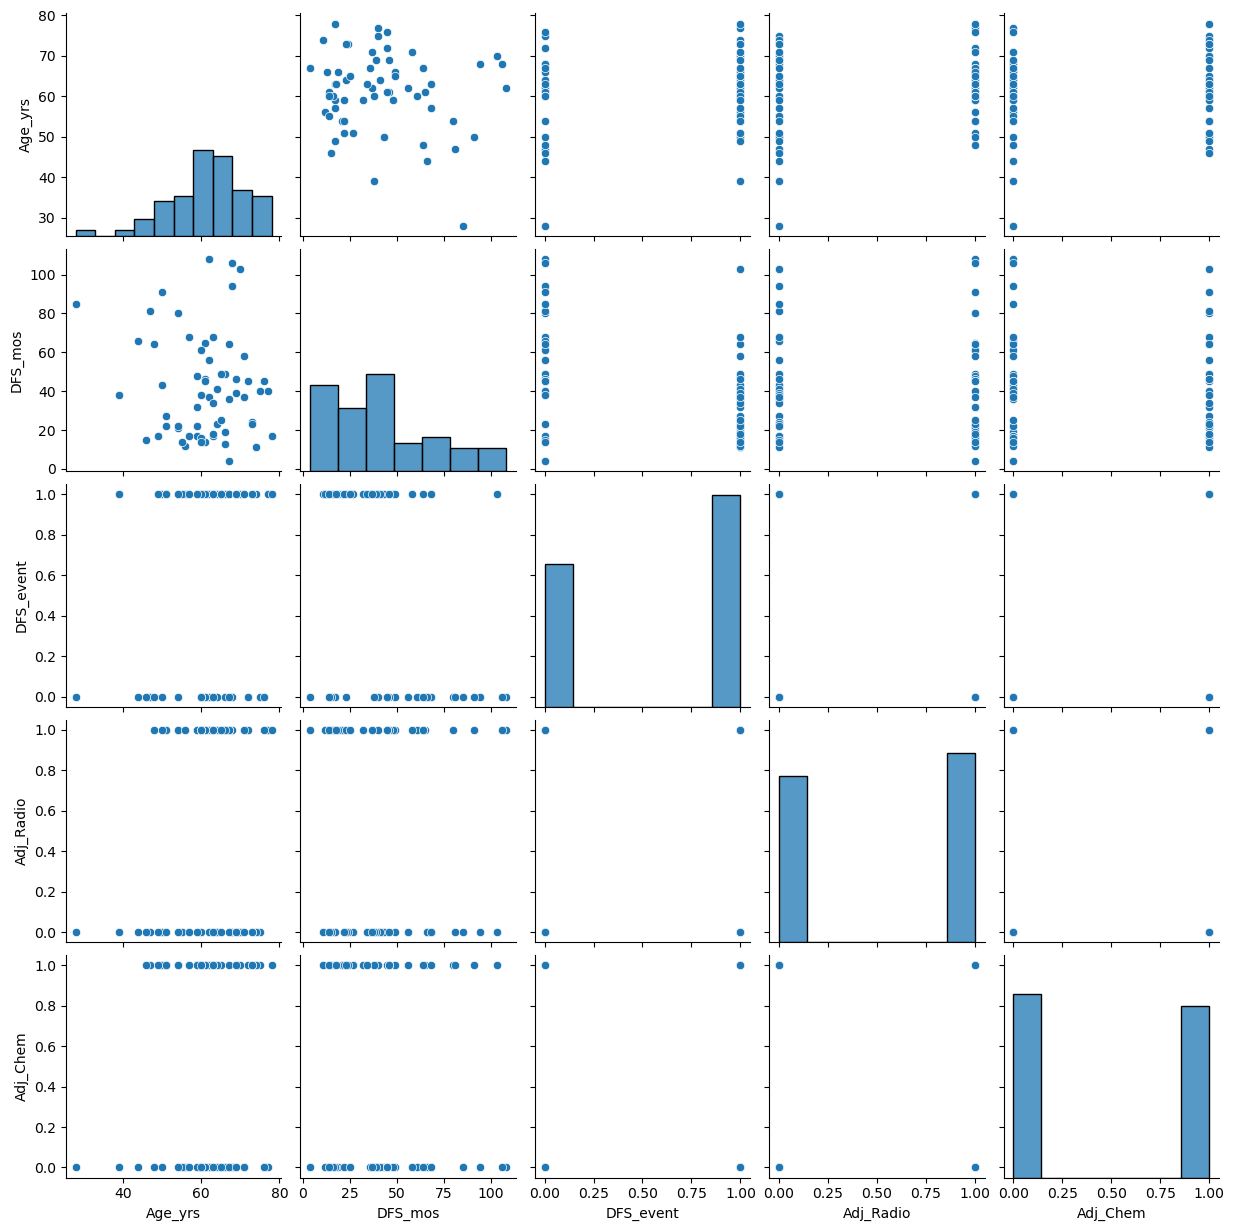

In [7]:
# start by cross-plotting all metadata continuous variables
sns.pairplot(df_pts)

# looks like there's not much correlation here other than DFS decreasing with increasing age

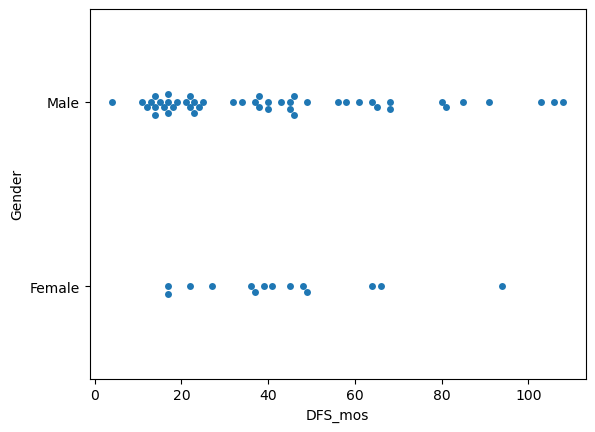

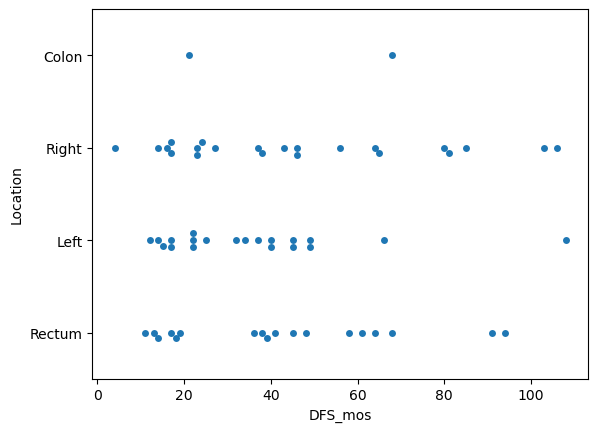

In [8]:
# now lets look at categorical variables
sns.swarmplot(data=df_pts, x="DFS_mos", y="Gender")
plt.show()
sns.swarmplot(data=df_pts, x="DFS_mos", y="Location")
plt.show()

# nothing obvious other than maybe somewhat better DFS with Right?

# Initial Survival Analysis
* include partitioning with clinical metadata

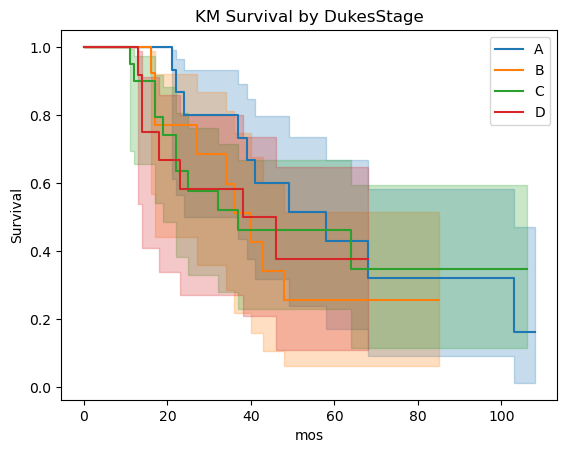

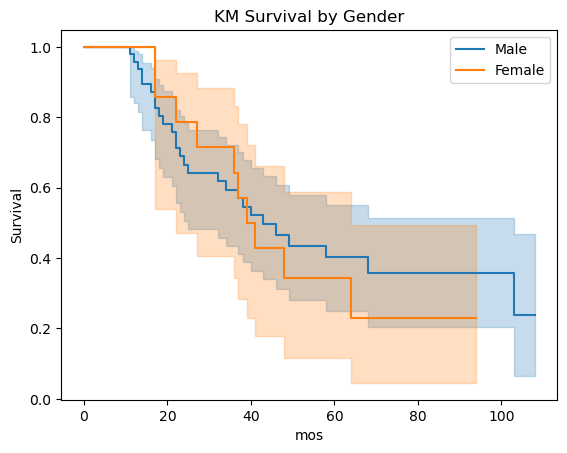

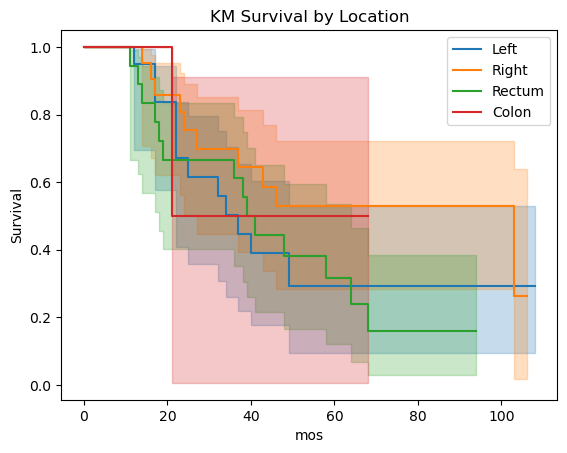

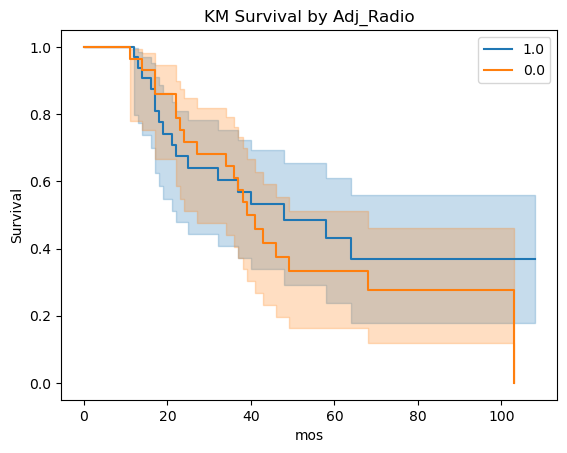

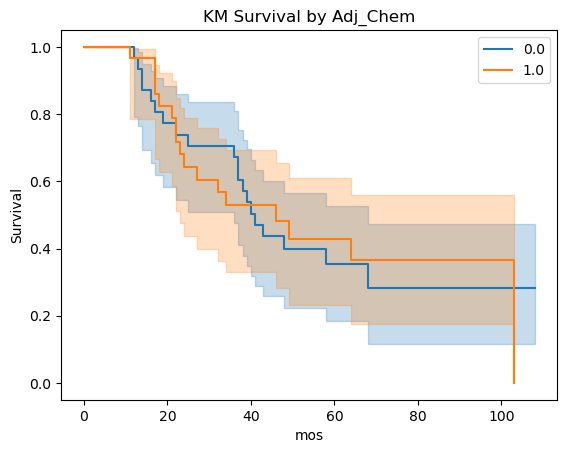

In [9]:
kmf = KaplanMeierFitter()
for categorical_variable in ["DukesStage", "Gender", "Location", "Adj_Radio", "Adj_Chem"]:
    categorical_values_uniq = df_pts.loc[:, categorical_variable].unique()
    for indx, categorical_value in enumerate(categorical_values_uniq):
        durations = df_pts.loc[df_pts[categorical_variable]==categorical_value, "DFS_mos"]
        events = df_pts.loc[df_pts[categorical_variable]==categorical_value, "DFS_event"]
        kmf.fit(durations, events, label=categorical_value)
        if indx == 0:
            ax = kmf.plot_survival_function()
        else:
            ax = kmf.plot_survival_function(ax=ax,
                                            title=f"KM Survival by {categorical_variable}",
                                            xlabel="mos", ylabel="Survival")
    ax.title
    plt.show()


In [10]:
# let's look at Cox Proportional Hazards regression for our covariates
## we need numerical values of covariates for the regression
df_cph_model = df_pts.loc[df_pts.Location!="Colon", :].copy()  # make a copy of the data for this CPH analysis dropping the two pts with ambiguous Location
# since we dropped a value of the categorical type we need to update the type
df_cph_model["Location"] = pd.Categorical(df_cph_model.Location,
                                          categories=["Right", "Left", "Rectum"],
                                          ordered=False)
DukesStage_map = {'A':1, 'B':2, 'C':3, 'D':4}
df_cph_model["DukesStage_int"] = df_cph_model.DukesStage.apply(lambda d: DukesStage_map[d])
Gender_map = {"Male":0, "Female":1}
df_cph_model["Gender_int"] = df_cph_model.Gender.apply(lambda g: Gender_map[g])
Location_map = {"Right":1, "Left":2, "Rectum":3}
df_cph_model["Location_int"] = df_cph_model.Location.apply(lambda c: Location_map[c])
cph = CoxPHFitter()
cph.fit(
    df_cph_model.loc[:, ["Age_yrs", "DukesStage_int", "Gender_int", "Location_int", "DFS_mos", "DFS_event", "Adj_Radio", "Adj_Chem"]],
     duration_col="DFS_mos", event_col="DFS_event")
cph.print_summary()

# so Location comes close to significance, but doesn't quite get there

<lifelines.CoxPHFitter: fitted with 60 total observations, 24 right-censored observations>
             duration col = 'DFS_mos'
                event col = 'DFS_event'
      baseline estimation = breslow
   number of observations = 60
number of events observed = 36
   partial log-likelihood = -121.24
         time fit was run = 2023-06-14 18:57:33 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age_yrs          0.02       1.02       0.02            -0.01             0.06                 0.99                 1.06
DukesStage_int   0.25       1.28       0.16            -0.07             0.57                 0.93                 1.76
Gender_int      -0.35       0.70       0.43            -1.19             0.49                 0.30                 1.63
Location_int     0.44       1.55       0.24            -0.04             0.91                 0.96                 2.49
Adj_Radio       -0.57       0.57       0.35            -1.26             0.13                 0.28                 1.14
Adj_Chem         0.07       1.07       0.39            -0.69             0.82                 0.50                 2.28

                 cmp to     z    p   -log2(p)
covariate                                    
Age_yrs            0.00  1.30 0.19       2.36
DukesStage_int     0.00  1.51 0.13       2.93
Gender_int         0.00 -0.82 0.41       1.28
Location_int       0.00  1.80 0.07       3.78
Adj_Radio          0.00 -1.60 0.11       3.19
Adj_Chem           0.00  0.18 0.86       0.22
---
Concordance = 0.62
Partial AIC = 254.48
log-likelihood ratio test = 7.52 on 6 df
-log2(p) of ll-ratio test = 1.86

# Initial EDA of Gene Expression Data
Note that GE values are already log2 transformed

In [11]:
df_ge = pd.read_csv("./data/Colorectal Cancer Gene Expression Data.csv", index_col="ID_REF")
df_ge.drop(columns=["rownum"], inplace=True)
df_ge = df_ge.transpose()
df_ge

ID_REF,117_at,1007_s_at,1053_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,1554911_at,1554912_at,1554914_at,1554915_a_at,1554916_a_at,1554918_a_at,1554919_s_at,1554920_at,213418_at,1554921_a_at
GSM877126,6.029834,9.468893,7.187090,6.807582,3.084591,7.397013,6.525426,3.848253,7.572331,3.748200,...,3.504809,2.856109,3.130712,5.603126,3.091348,4.009692,4.350400,2.512026,7.494499,4.030978
GSM877127,6.344321,9.994204,7.705626,6.893130,3.118704,7.163797,6.391195,4.202085,8.295322,3.114340,...,3.957833,2.988643,3.484177,6.601744,3.141737,4.679732,4.508760,2.427697,8.156995,2.827090
GSM877128,5.023127,10.409823,7.934057,7.165602,2.984632,7.375224,5.538846,4.074462,7.055579,4.172270,...,3.749518,2.610840,3.406207,6.003205,3.469987,4.781843,4.435054,2.531300,6.058687,2.930454
GSM877129,4.612727,10.596921,7.446374,7.071417,2.912851,7.596233,5.989148,3.738205,9.683806,3.625413,...,3.610429,2.728274,3.534871,5.858326,3.372291,3.653575,5.014994,2.608755,5.488072,2.949848
GSM877130,5.865944,10.252547,7.141105,7.103383,3.383726,7.278244,5.678236,4.141955,7.360892,3.338311,...,3.520434,2.664744,3.314746,5.388115,3.322147,4.666360,5.013006,2.657130,7.410725,3.054697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM877184,4.835558,10.343581,7.471584,7.920227,2.888331,7.628249,6.061266,3.728707,7.830382,3.161023,...,3.637413,2.787781,3.519436,6.026848,3.404074,4.103411,4.303329,2.422700,6.072618,2.853109
GSM877185,5.694010,9.409749,7.488735,6.699796,3.201511,7.192814,5.928451,3.675157,7.271917,3.392471,...,3.733335,3.473473,3.237316,6.167214,3.452096,4.724017,4.470426,2.634358,7.175365,2.667533
GSM877186,8.661629,10.427298,7.512632,7.046389,2.650723,5.992824,5.285014,4.047409,5.335867,3.381974,...,3.436002,2.706722,3.349033,6.238026,3.109042,6.897634,3.797626,2.756086,10.121831,2.971542
GSM877187,5.702601,10.309094,7.476872,7.349701,2.858642,6.878941,6.137371,3.863878,8.280592,3.222998,...,3.438260,2.539084,3.334590,5.842051,3.496104,4.883845,4.661893,2.581452,7.232090,2.719928


In [12]:
df_ge.describe()

ID_REF,117_at,1007_s_at,1053_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,1554911_at,1554912_at,1554914_at,1554915_a_at,1554916_a_at,1554918_a_at,1554919_s_at,1554920_at,213418_at,1554921_a_at
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,...,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,5.707784,10.220618,7.533482,7.331769,2.982030,7.279824,5.982484,3.885063,7.737473,3.460415,...,3.722569,2.697402,3.445108,5.849156,3.437122,4.319765,4.530284,2.580418,7.007763,2.886002
std,1.141096,0.506397,0.448784,0.346860,0.181438,0.526905,0.353695,0.185737,1.364183,0.287547,...,0.194573,0.191073,0.182877,0.466693,0.267659,0.648902,0.329638,0.107296,1.362131,0.274488
min,4.285183,7.754544,6.119306,6.699796,2.650723,5.992824,5.285014,3.499041,4.685060,3.114340,...,3.251912,2.397467,2.994022,4.711967,2.709493,3.168259,3.668514,2.329777,4.983739,2.596916
25%,4.917209,10.010747,7.306200,7.077712,2.860146,7.007140,5.738839,3.742372,7.057896,3.306567,...,3.613045,2.571041,3.323543,5.539251,3.289856,3.894832,4.373952,2.515328,5.864103,2.733037
50%,5.363241,10.239241,7.500395,7.263498,2.956179,7.231809,5.989217,3.858752,7.652836,3.391923,...,3.720273,2.677127,3.438560,5.863188,3.399116,4.205774,4.543968,2.581821,6.831109,2.844452
75%,6.261369,10.545181,7.763559,7.545533,3.070789,7.566110,6.271426,4.020531,8.673869,3.496251,...,3.841272,2.795925,3.572996,6.161970,3.554152,4.676389,4.682515,2.654503,7.687362,2.929875
max,10.368146,10.996956,8.810034,8.588304,3.572938,8.969693,6.622151,4.332709,10.774562,4.758090,...,4.358848,3.473473,3.861362,6.852246,4.414884,6.897634,5.241488,2.764213,11.694707,4.030978


In [13]:
# are there any na-values in the GE data?
df_ge.isna().sum().max()

# looks like there are not :)

0

In [14]:
# compute probeset cvs which will help us see which probesets have variation that MAY BE correlated with treatments
probeset_cvs = df_ge.transpose().apply(lambda row: row.std() / row.mean(), axis=1)
probeset_cvs

ID_REF
117_at          0.199919
1007_s_at       0.049547
1053_at         0.059572
121_at          0.047309
1255_g_at       0.060844
                  ...   
1554918_a_at    0.150217
1554919_s_at    0.072763
1554920_at      0.041581
213418_at       0.194375
1554921_a_at    0.095110
Length: 1935, dtype: float64

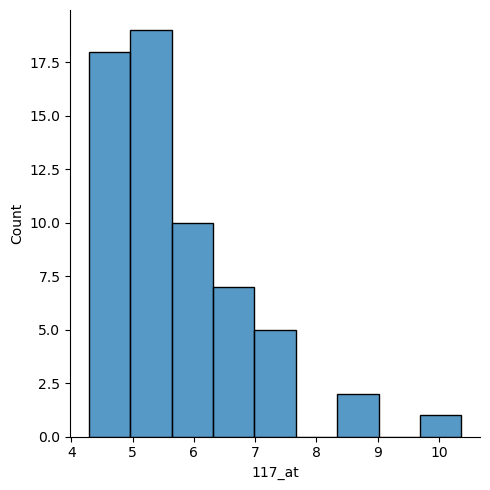

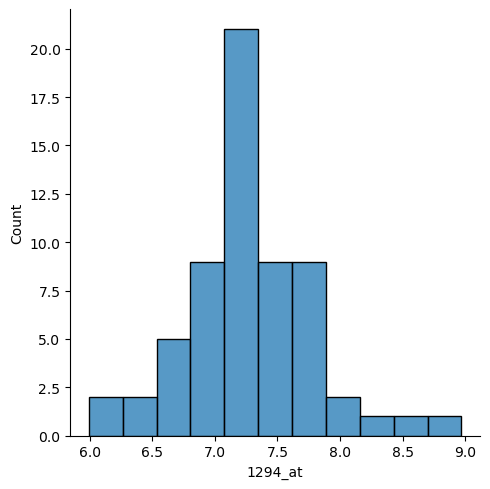

In [15]:
# what do the distributions of GE values look like for a few genes?
sns.displot(df_ge, x="117_at")
plt.show()
sns.displot(df_ge, x="1294_at")
plt.show()


In [16]:
# to run CPH model for a gene (probeset) we need a df with three columns:
## index: ID_REF
## duration: DFS_mos from df_pts
## event: DFS_event from df_pts
## probeset_id: log2(GE) values from df_ge
for indx, probeset in enumerate(df_ge.columns):
    df_probeset = pd.merge(df_pts.loc[:, ["DFS_mos", "DFS_event"]], df_ge.loc[:, probeset], left_index=True, right_index=True)
    cph = CoxPHFitter()
    cph.fit(df_probeset, duration_col="DFS_mos", event_col="DFS_event")
    #cph.print_summary()
    df_probeset = cph.summary
    if indx == 0:
        df_cph = df_probeset
    else:
        df_cph = pd.concat([df_cph, df_probeset])

# and now we can do an fdr correction on the pvals
fdr05_sig, pval_corrected = fdrcorrection(df_cph.p, alpha=0.05)
df_cph["fdr05_sig"] = fdr05_sig
df_cph["pval_corrected"] = pval_corrected
df_cph

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),fdr05_sig,pval_corrected
covariate,,,,,,,,,,,,,
117_at,-0.095194,0.909197,0.168945,-0.426319,0.235932,0.652908,1.266088,0.0,-0.563462,0.573121,0.803090,False,0.988107
1007_s_at,0.743502,2.103287,0.362651,0.032718,1.454285,1.033259,4.281423,0.0,2.050182,0.040347,4.631406,False,0.985356
1053_at,-0.114713,0.891622,0.387002,-0.873224,0.643798,0.417603,1.903697,0.0,-0.296415,0.766913,0.382865,False,0.989005
121_at,-0.098886,0.905846,0.446486,-0.973983,0.776212,0.377576,2.173224,0.0,-0.221475,0.824722,0.278019,False,0.989005
1255_g_at,-1.128266,0.323594,1.077931,-3.240972,0.984439,0.039126,2.676311,0.0,-1.046696,0.295240,1.760042,False,0.985356
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554918_a_at,-0.274193,0.760185,0.287992,-0.838647,0.290260,0.432295,1.336775,0.0,-0.952087,0.341053,1.551933,False,0.985356
1554919_s_at,0.104783,1.110469,0.500813,-0.876792,1.086357,0.416116,2.963459,0.0,0.209225,0.834273,0.261409,False,0.989005
1554920_at,1.845438,6.330871,1.602941,-1.296269,4.987145,0.273551,146.517480,0.0,1.151282,0.249616,2.002217,False,0.985356


In [17]:
# let's see how many fdr_corrected_pvals are significant
df_cph.loc[df_cph.p<0.05, :].sort_values(by="p", ascending=True)

# There are ZERO fdf-corrected significant genes!

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),fdr05_sig,pval_corrected
covariate,,,,,,,,,,,,,
1553162_x_at,-2.005513,0.134591,0.570886,-3.124429,-0.886596,0.043962,0.412056,0.0,-3.512981,0.000443,11.140049,False,0.833429
1553027_a_at,-3.843220,0.021425,1.227762,-6.249589,-1.436851,0.001931,0.237675,0.0,-3.130265,0.001746,9.161328,False,0.833429
1552798_a_at,-1.278519,0.278449,0.411655,-2.085347,-0.471690,0.124264,0.623947,0.0,-3.105802,0.001898,9.041581,False,0.833429
1554417_s_at,1.587388,4.890959,0.525223,0.557970,2.616807,1.747122,13.691937,0.0,3.022311,0.002509,8.638946,False,0.833429
1552794_a_at,1.921577,6.831722,0.641387,0.664481,3.178672,1.943482,24.014841,0.0,2.995971,0.002736,8.513861,False,0.833429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554504_at,-4.204373,0.014930,2.122582,-8.364557,-0.044189,0.000233,0.956773,0.0,-1.980783,0.047616,4.392420,False,0.985356
1552398_a_at,-0.915490,0.400320,0.462612,-1.822193,-0.008787,0.161671,0.991251,0.0,-1.978959,0.047821,4.386223,False,0.985356
1552399_a_at,-2.277255,0.102565,1.152985,-4.537065,-0.017445,0.010705,0.982706,0.0,-1.975094,0.048257,4.373105,False,0.985356


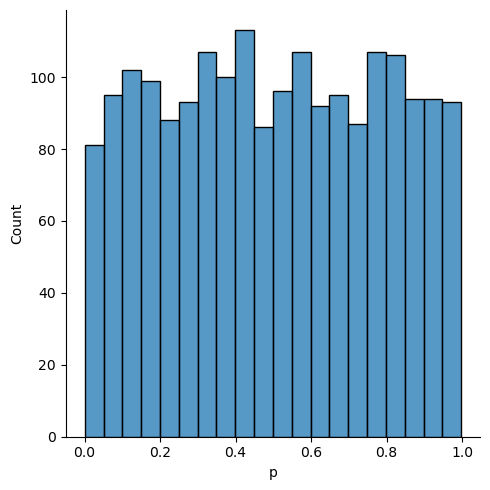

In [18]:
# let's look at the distribution of the CPH (uncorrected) pvals
sns.displot(df_cph, x="p", bins=20)

# this shows that there are not any "excess" pvals<0.05, which is what the fdr result is telling us

# Probeset annotations
At ensemble.org we can search for a probeset id, e.g. 1007_s_at
http://www.ensembl.org/Multi/Search/Results?q=1007_s_at;site=ensembl_all;page=1
AFFY probeset 1007_s_at on array HG_U95A has 16 probes which align to the genome in 80 locations.
These 16 probes seem to map to 54 transcripts, which all seem to be related to gene:DDR1

http://www.ensembl.org/Multi/Search/Results?q=1552398_a_at;site=ensembl_all;page=1
AFFY probeset 1552398_a_at on array HG-U133_Plus_2 has 11 probes which align to the genome in 11 locations.
And these 11 probes seem to map to 4 transcripts, which all seem to be related to the gene:CLEC12A

Looks like we can get this info from a REST-API here:
https://rest.ensembl.org/regulatory/species/homo_sapiens/microarray/HG-U133_Plus_2/probe_set/1007_s_at?content-type=application/json;gene=1;transcript=1

See overall instructions for REST-API here:
https://rest.ensembl.org/

Kind of guessing that this HG-U133_Plus_2 is an appropriate microarray ... we could try this for all our probesets and see if we miss any.

Here's a nice description of Affy probeset ids and how to think about analyzing them:
https://www.reddit.com/r/bioinformatics/comments/544zqi/comment/d7zpcxj/?utm_source=share&utm_medium=web2x

In [19]:
# let's use the ensemble REST-API to get annotations for all the probes in the dataset

# since there are many transcripts per probeset and possibly many probesets per transcript
# (we'll see), we use a sqlite-db to hold this possibly many-to-many relationship.

# query ensembl REST-API for the probeset annotations
probesets_json = get_probeset_json(df_ge.columns.tolist())

In [20]:
probesets_json[0]

{'probes': ['1104:1117;',
  '130:903;',
  '479:755;',
  '493:789;',
  '568:955;',
  '60:815;',
  '643:1013;',
  '643:141;',
  '720:423;',
  '823:375;',
  '832:1147;',
  '835:463;',
  '921:1141;',
  '970:195;',
  '973:193;',
  '985:529;'],
 'size': 16,
 'microarray': 'HG-U133_Plus_2',
 'name': '117_at',
 'transcripts': [{'description': '9 out of 16 probes from this probeset have been mapped to this transcript. The probeset matches 1 other transcripts.',
   'gene': {'stable_id': 'ENSG00000225217', 'external_name': 'HSPA7'},
   'stable_id': 'ENST00000445535'},
  {'description': '16 out of 16 probes from this probeset have been mapped to this transcript. The probeset matches 1 other transcripts.',
   'gene': {'external_name': 'HSPA6', 'stable_id': 'ENSG00000173110'},
   'stable_id': 'ENST00000309758'}]}

In [21]:
# now let's build a df with one row per probeset-transcript
## here are the columns:

def get_transcript_numprobes(description):
    pattern = r"(^[0-9]+) out of ([0-9]+) probes from this probeset"
    p = re.compile(pattern)
    match = p.match(description)
    if match:
        numprobes = int(match[1])
    else:
        err_msg = f"failed to find {pattern}\nin\n{description}\nso can't get numprobes."
        raise ValueError(err_msg)
    return numprobes

probeset_size = []
probeset_name = []
transcript_id = []
transcript_numprobes = []
gene_id = []
gene_name = []
for probeset in probesets_json:
    for transcript in probeset["transcripts"]:
        probeset_name.append(probeset["name"])
        probeset_size.append(probeset["size"])
        transcript_id.append(transcript["stable_id"])
        transcript_numprobes.append(get_transcript_numprobes(transcript["description"]))
        gene_id.append(transcript["gene"]["stable_id"])
        gene_name.append(transcript["gene"]["external_name"])

probesets_transcripts_df = pd.DataFrame({
    "probeset": probeset_name,
    "transcript": transcript_id,
    "probeset_size": probeset_size,
    "transcript_numprobes": transcript_numprobes,
    "gene_id": gene_id,
    "gene_name": gene_name
})


In [22]:
probesets_transcripts_df

,probeset,transcript,probeset_size,transcript_numprobes,gene_id,gene_name
0,117_at,ENST00000445535,16,9,ENSG00000225217,HSPA7
1,117_at,ENST00000309758,16,16,ENSG00000173110,HSPA6
2,1007_s_at,ENST00000376567,16,16,ENSG00000204580,DDR1
3,1007_s_at,ENST00000400411,16,16,ENSG00000137332,DDR1
4,1007_s_at,ENST00000550666,16,16,ENSG00000230456,DDR1
...,...,...,...,...,...,...
7392,1554921_a_at,ENST00000377246,11,10,ENSG00000136155,SCEL
7393,1554921_a_at,ENST00000469982,11,8,ENSG00000136155,SCEL
7394,1554921_a_at,ENST00000349847,11,10,ENSG00000136155,SCEL
7395,1554921_a_at,ENST00000471491,11,11,ENSG00000136155,SCEL


In [23]:
# are there transcripts that appear multiple times?  These could be transcripts that are addressed
# by multiple probesets
len(probesets_transcripts_df.transcript.unique())

# since the number of unique transcripts is less than the number of rows, this may be the case.

6556

In [24]:
# how many transcripts appear how many times?
transcript_occurances = probesets_transcripts_df.transcript.value_counts()
transcript_occurances.value_counts()

1    5756
2     759
3      41
Name: transcript, dtype: int64

In [25]:
# let's add transcript_occurances to the probesets_transcripts_df
probesets_transcripts_df["transcript_occurances"] = probesets_transcripts_df.apply(lambda row: transcript_occurances[row.transcript], axis=1)
probesets_transcripts_df

,probeset,transcript,probeset_size,transcript_numprobes,gene_id,gene_name,transcript_occurances
0,117_at,ENST00000445535,16,9,ENSG00000225217,HSPA7,2
1,117_at,ENST00000309758,16,16,ENSG00000173110,HSPA6,2
2,1007_s_at,ENST00000376567,16,16,ENSG00000204580,DDR1,1
3,1007_s_at,ENST00000400411,16,16,ENSG00000137332,DDR1,1
4,1007_s_at,ENST00000550666,16,16,ENSG00000230456,DDR1,1
...,...,...,...,...,...,...,...
7392,1554921_a_at,ENST00000377246,11,10,ENSG00000136155,SCEL,1
7393,1554921_a_at,ENST00000469982,11,8,ENSG00000136155,SCEL,1
7394,1554921_a_at,ENST00000349847,11,10,ENSG00000136155,SCEL,1
7395,1554921_a_at,ENST00000471491,11,11,ENSG00000136155,SCEL,2


In [26]:
# now let's add the probeset_cv to the probesets_transcripts_df
probesets_transcripts_df["probeset_cv"] = probesets_transcripts_df.apply(lambda row: probeset_cvs[row.probeset], axis=1)
probesets_transcripts_df

,probeset,transcript,probeset_size,transcript_numprobes,gene_id,gene_name,transcript_occurances,probeset_cv
0,117_at,ENST00000445535,16,9,ENSG00000225217,HSPA7,2,0.199919
1,117_at,ENST00000309758,16,16,ENSG00000173110,HSPA6,2,0.199919
2,1007_s_at,ENST00000376567,16,16,ENSG00000204580,DDR1,1,0.049547
3,1007_s_at,ENST00000400411,16,16,ENSG00000137332,DDR1,1,0.049547
4,1007_s_at,ENST00000550666,16,16,ENSG00000230456,DDR1,1,0.049547
...,...,...,...,...,...,...,...,...
7392,1554921_a_at,ENST00000377246,11,10,ENSG00000136155,SCEL,1,0.095110
7393,1554921_a_at,ENST00000469982,11,8,ENSG00000136155,SCEL,1,0.095110
7394,1554921_a_at,ENST00000349847,11,10,ENSG00000136155,SCEL,1,0.095110
7395,1554921_a_at,ENST00000471491,11,11,ENSG00000136155,SCEL,2,0.095110


In [27]:
# let's look for transcripts that have multiple probesets AND have relatively high probeset_cvs
probesets_transcripts_df.loc[
    (probesets_transcripts_df.transcript_occurances>1) & (probesets_transcripts_df.probeset_cv>0.15), :
].sort_values(by=["transcript"])

# perhaps we revist the CPH model with these transcripts as variables
# . could compute a sample-transcript GE value by averaging the values
# . over the probesets in the transcript??

,probeset,transcript,probeset_size,transcript_numprobes,gene_id,gene_name,transcript_occurances,probeset_cv
241,1552306_at,ENST00000266483,11,11,ENSG00000139133,ALG10,2,0.169480
1409,1552727_s_at,ENST00000268070,11,11,ENSG00000140470,ADAMTS17,3,0.173989
4331,1553989_a_at,ENST00000272238,11,11,ENSG00000143882,ATP6V1C2,2,0.190034
681,1552532_a_at,ENST00000272238,11,11,ENSG00000143882,ATP6V1C2,2,0.240152
1303,1552691_at,ENST00000282026,11,11,ENSG00000152213,ARL11,2,0.255682
...,...,...,...,...,...,...,...,...
4805,1554127_s_at,ENST00000642411,11,8,ENSG00000174099,MSRB3,2,0.160286
5200,1554242_a_at,ENST00000643575,11,11,ENSG00000100473,COCH,2,0.271054
4801,1554127_s_at,ENST00000646299,11,8,ENSG00000174099,MSRB3,2,0.160286
343,1552349_a_at,ENST00000682474,11,11,ENSG00000103355,PRSS33,2,0.336619


In [28]:
# e.g. 
df_ge.loc[:, ["1552349_a_at", "1552348_at"]]

ID_REF,1552349_a_at,1552348_at
GSM877126,3.467443,4.407475
GSM877127,3.157303,4.368247
GSM877128,3.368064,4.363488
GSM877129,3.501691,4.788979
GSM877130,3.676973,4.721074
...,...,...
GSM877184,8.127850,9.696932
GSM877185,3.397146,3.857643
GSM877186,3.102692,3.911677
GSM877187,4.887181,7.185789


<AxesSubplot:xlabel='1552349_a_at', ylabel='1552348_at'>

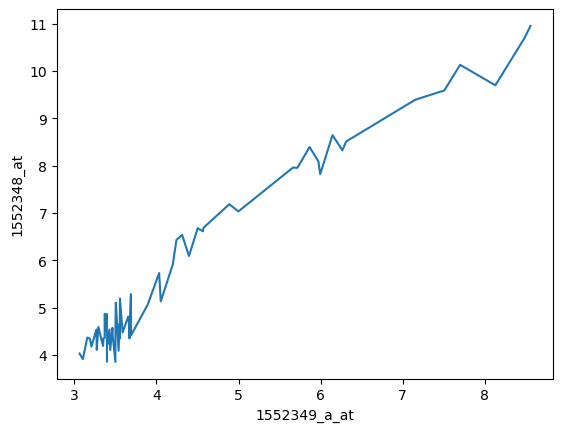

In [29]:
df_to_plot = df_ge.loc[:, ["1552349_a_at", "1552348_at"]]
sns.lineplot(df_to_plot, x="1552349_a_at", y="1552348_at")

# this transcript seems to have pretty wide variation in ge values
# and the values for the two probes seem pretty well correlated
# such that using something like avg of the probe values for the 
# transcript is likely ok